# Diagnóstico Inicial do Cancelamento - CCAAB

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_percentage(df, x, y, xlabel):   
    counts = df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    print(counts)
    g = sns.catplot(x=x, y='percent', hue=y, data=counts, kind='bar')
    
    g.set(xlabel = xlabel)
    
    new_title = 'Cancelamento'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ['Não', 'Sim']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.show()

df = pd.read_csv('/home/ramon/extrator/survival/evasao-100.csv')

In [2]:
def permutation_test(events, obs_diff, n1):
    n = len(events)
    n2 = n-n1
    idxs = np.arange(0, n)



    values = []
    for i in range(10000):
        foo = np.full(n, False)
        idx_a = np.random.choice(idxs, n1, replace=False)
        foo[idx_a] = True

        diff = np.abs(events[foo].mean() - events[~foo].mean())
        values.append(diff)

    return (np.mean(np.array(values) > obs_diff))

def proportion_test(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    counts = df[idx].groupby(col_name)['event'].mean().values
    obs_diff = np.abs(counts[0] - counts[1])
    n1 = df[idx][col_name].value_counts().values[0]
    events = df.loc[idx, 'event'].values
    
    return (permutation_test(events, obs_diff, n1))

from statsmodels.stats.proportion import proportions_ztest

def proportion_test2(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    count = df[idx].groupby(col_name)['event'].sum().values
    nobs = df[idx].groupby(col_name)['event'].count().values

    stat, pval = proportions_ztest(count, nobs)
    return pval

In [3]:
centro  = 'CCAAB'
df = df[df.centro == centro]

In [4]:
df.groupby('time')['event'].value_counts()

time  event
1     0        4487
      1        1295
2     0        3943
      1         502
3     0        3476
      1         295
4     0        2975
      1         246
5     0        2614
      1         194
6     0        2302
      1         110
7     0        2024
      1          86
8     0        1720
      1          63
9     0        1471
      1          63
10    0        1180
      1          37
11    0         790
      1          18
12    0         479
      1          17
13    0         314
      1          16
14    0         179
      1          12
15    0         104
      1           3
16    0          59
      1           4
17    0          37
      1           3
18    0          18
      1           1
19    0           8
      1           1
Name: event, dtype: int64

# Perfil dos Estudantes na Amostra

- 51% cancelaram
- 79% possuem cidade de origem diferente da cidade do campus
- 55% são do sexo feminino
- Idade média dos estudantes é 23
- Há 5782 números de matrículas

In [5]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

print(df[idx]['event'].value_counts(normalize=True))

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

print(df[idx]['sexo'].value_counts(normalize=True))

print(df[idx]['idade_ingresso'].mean())

print(df.matricula.nunique())

1    0.512971
0    0.487029
Name: event, dtype: float64
1    0.785714
0    0.214286
Name: is_outra_cidade, dtype: float64
0    0.554306
1    0.445694
Name: sexo, dtype: float64
23.07557938429609
5782


# Q1 Taxa de cancelamento é maior para estudantes cuja cidade de origem difere da cidade do campus?


- Taxa é maior para discentes naturais (54% vs 51%)
- Diferença observada é estatisticamente significativa

1    0.785714
0    0.214286
Name: is_outra_cidade, dtype: float64
   is_outra_cidade  event    percent
0                0      1  54.156578
1                0      0  45.843422
2                1      1  50.517279
3                1      0  49.482721


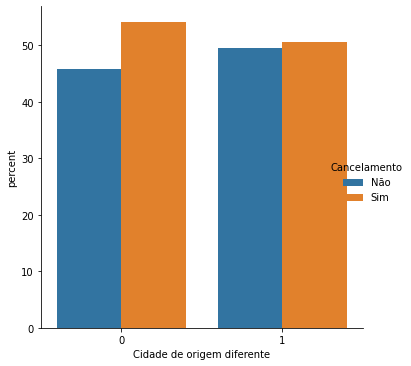

In [6]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_outra_cidade', 'event', 'Cidade de origem diferente')

In [7]:
#print('%.3f'%(proportion_test(df, 'is_outra_cidade')))
print(proportion_test2(df, 'is_outra_cidade'))

0.023101198692300526


# Q2 Taxa de cancelamento é maior para ingressantes no 1o semestre ou 2o semestre letivo? (Ex: taxa de cancelamento é maior para ingressantes em 2019.1 ou 2019.2?)

- Taxa é maior entre ingressantes no 1o semestre (54% vs 47%)
- A diferença é estatisticamente significativa

1    0.60377
2    0.39623
Name: semestreIngresso, dtype: float64
   semestreIngresso  event    percent
0                 1      1  54.425666
1                 1      0  45.574334
2                 2      0  53.470100
3                 2      1  46.529900


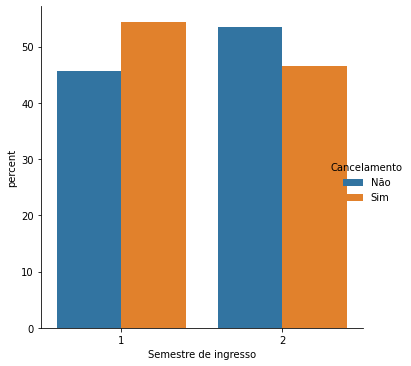

In [8]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['semestreIngresso'].value_counts(normalize=True))

plot_percentage(df[idx], 'semestreIngresso', 'event', 'Semestre de ingresso')

In [9]:
#print('%.3f'%(proportion_test(df, 'periodoingresso')))
print(proportion_test2(df, 'semestreIngresso'))

4.224625220236724e-09


# Q4 Taxa taxa de cancelamento é maior para homens ou mulheres?

- Taxa é maior para homens (55% vs 48%)
- Diferença observada é significativa

0    0.554306
1    0.445694
Name: sexo, dtype: float64
   sexo  event    percent
0     0      0  51.669267
1     0      1  48.330733
2     1      1  54.986418
3     1      0  45.013582


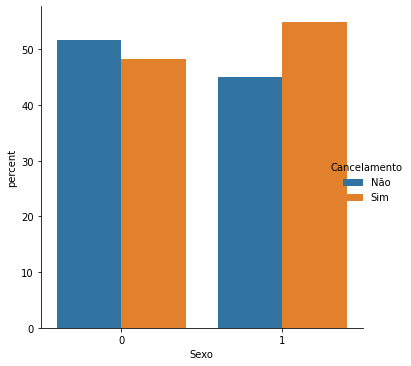

In [10]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['sexo'].value_counts(normalize=True))

plot_percentage(df[idx], 'sexo', 'event', 'Sexo')

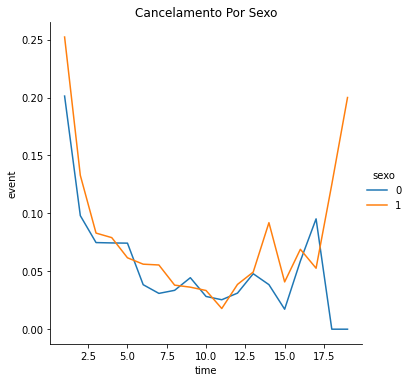

In [11]:
data = df.groupby(['time','sexo']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='sexo',  kind="line")    
ax.set(title='Cancelamento Por Sexo')    

In [12]:
#print('%.3f'%(proportion_test(df, 'sexo')))
print(proportion_test2(df, 'sexo'))

4.836168957797507e-07


# Q5 Taxa de cancelamento decresce com o tempo?

- A taxa tende a decrescer com o tempo

[Text(0.5, 1.0, 'Cancelamento Geral')]

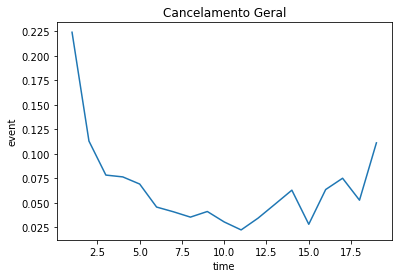

In [13]:
data = df.groupby('time').agg({'event':'mean'}).reset_index()

ax = sns.lineplot(x='time', y='event', data=data)    
ax.set(title='Cancelamento Geral')

# Q6 Taxa de cancelamento difere entre ingressantes por cota e ampla concorrência?

- A taxa é maior para Ampla Concorrência (52% vs 51%)
- A diferença observada não é estatisticamente significativa

0    0.51349
1    0.48651
Name: is_cotista, dtype: float64
   is_cotista  event    percent
0           0      1  51.902998
1           0      0  48.097002
2           1      1  50.657661
3           1      0  49.342339


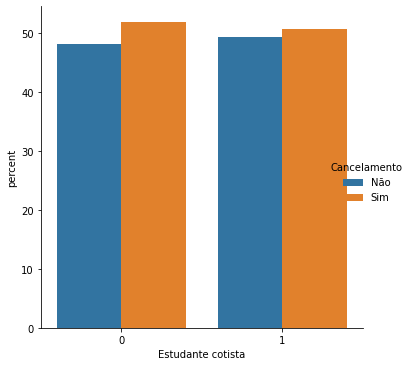

In [14]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_cotista'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_cotista', 'event', 'Estudante cotista')

In [15]:
#print('%.3f'%(proportion_test(df, 'is_cotista')))
print(proportion_test2(df, 'is_cotista'))

0.34367883902175256


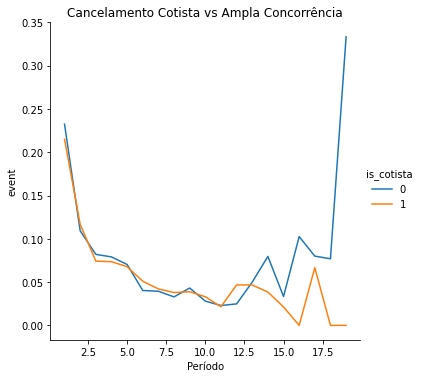

In [16]:
data = df.groupby(['time','is_cotista']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='is_cotista',  kind="line")    
ax.set(title='Cancelamento Cotista vs Ampla Concorrência', xlabel='Período')    

# Q.7 A idade de ingresso afeta a taxa de cancelamento?

- A idade de ingresso parece afetar a taxa

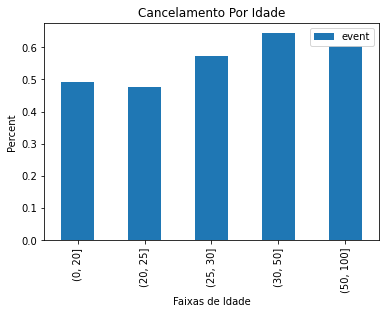

In [17]:
col = 'idade_cat'
df[col] = pd.cut(df.idade_ingresso, bins=[0,20,25,30,50,100])


ax = df[idx].groupby(col).agg({'event':'mean'}).plot.bar()
ax.set(ylabel="Percent")
ax.set(title='Cancelamento Por Idade', xlabel='Faixas de Idade')
plt.show()

# Turno afeta Cancelamento?

In [18]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('turno').agg({'event':'mean'})

,event
turno,
Matutino e Vespertino,0.516978
Noturno,0.499625


# Grau afeta Cancelamento?

In [19]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('grau').agg({'event':'mean'})

,event
grau,
Bacharelado,0.513105
Licenciatura,0.452017
Tecnológico,0.552511


# Análise Bivariada

Idade Ingresso vs Turno


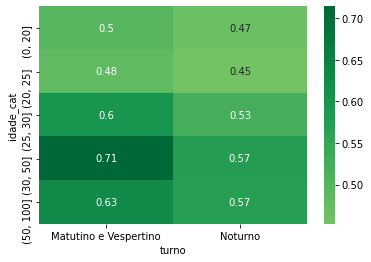

Idade Ingresso vs Grau do Curso


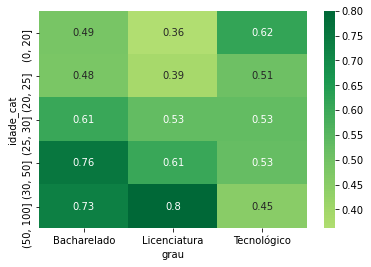

Idade Ingresso vs Sexo


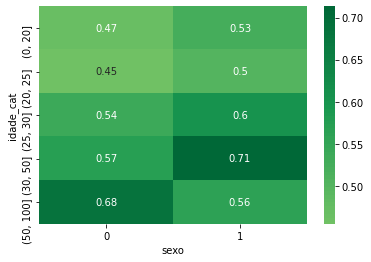

Idade Ingresso vs Cotista


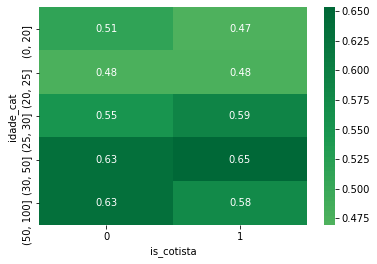

Idade Ingresso vs Migrante


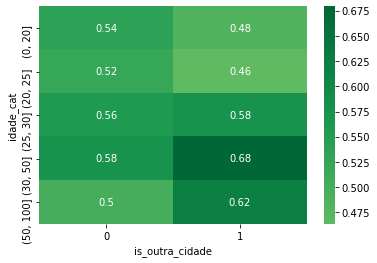

Idade Ingresso vs Período


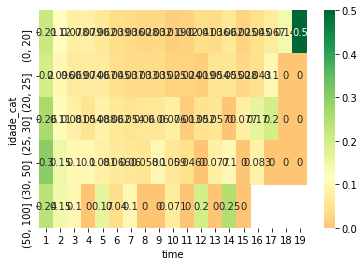

Turno vs Grau do Curso


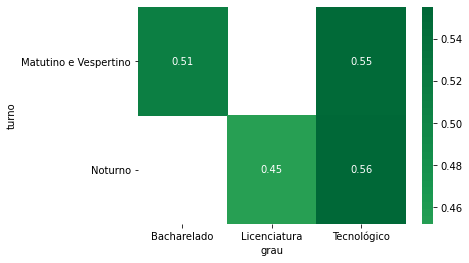

Turno vs Sexo


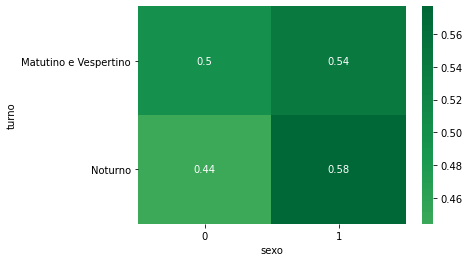

Turno vs Cotista


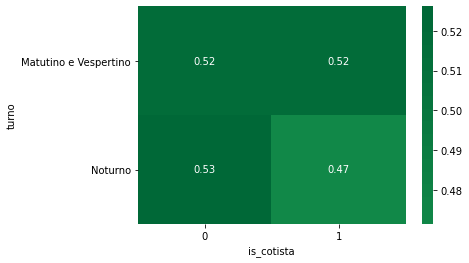

Turno vs Migrante


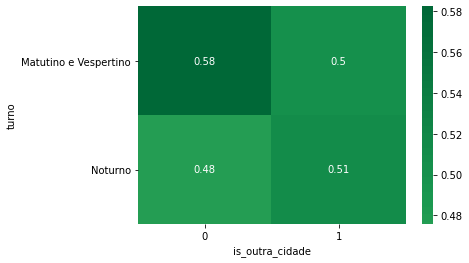

Turno vs Período


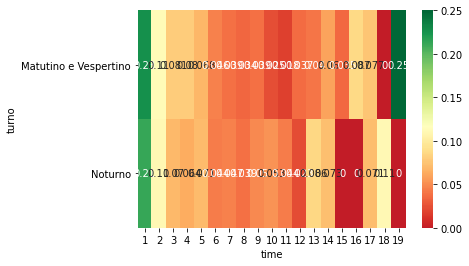

Grau do Curso vs Sexo


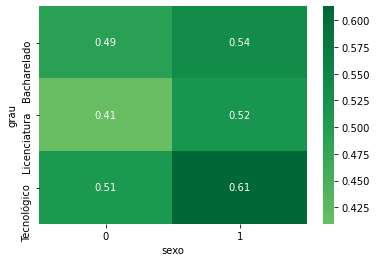

Grau do Curso vs Cotista


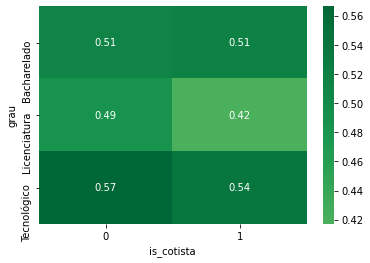

Grau do Curso vs Migrante


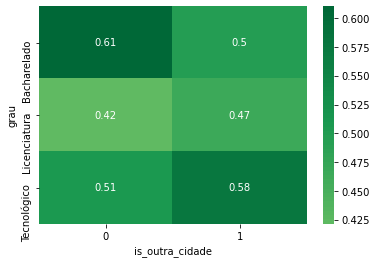

Grau do Curso vs Período


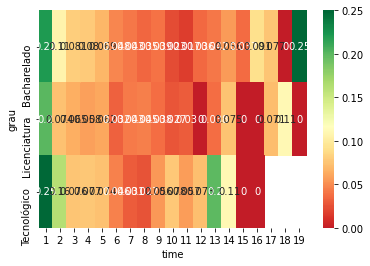

Sexo vs Cotista


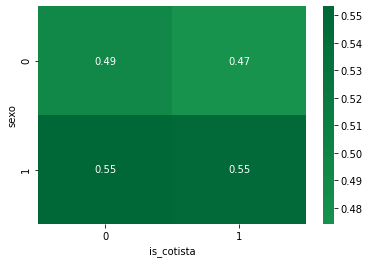

Sexo vs Migrante


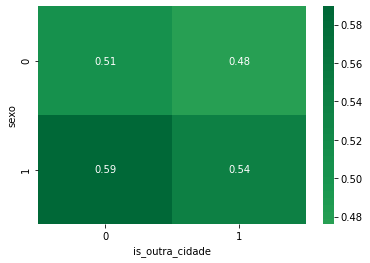

Sexo vs Período


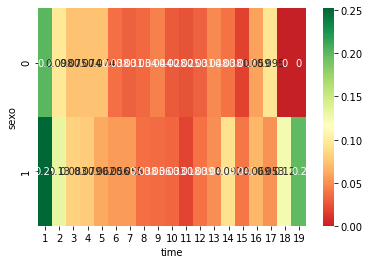

Cotista vs Migrante


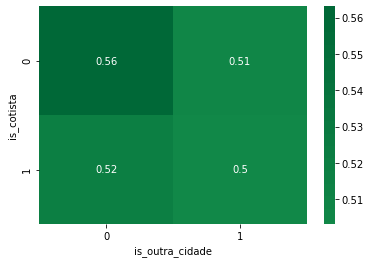

Cotista vs Período


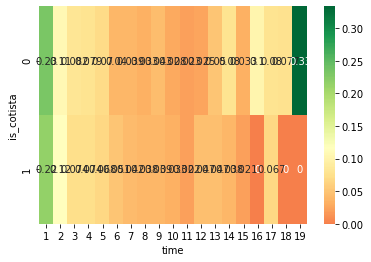

Migrante vs Período


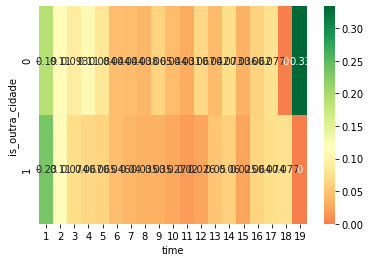

In [20]:
nomes = ['Idade Ingresso', 'Turno', 'Grau do Curso', 'Sexo', 'Cotista', 'Migrante', 'Período']
x = ['idade_cat', 'turno', 'grau', 'sexo', 'is_cotista',  'is_outra_cidade', 'time']

idx = df['time'] == df.groupby('matricula')['time'].transform('max')


for i in range(0, len(x)):
    for j in range(i+1, len(x)):
        print('%s vs %s'%(nomes[i], nomes[j]))
        if x[j] == 'time':
            result = pd.pivot_table(data=df, index=x[i], columns=x[j], values='event')
        else:
            result = pd.pivot_table(data=df[idx], index=x[i], columns=x[j], values='event')
        sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
        plt.show()